In [1]:
import nibabel as nb 
import numpy as np
import pandas as pd  
from scipy.stats import linregress, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
from Functional_Fusion.dataset import decompose_pattern_into_group_indiv_noise
from scripts import decomposing_variances
from scripts import make_atlas
#from scripts import bold_normalization 
import Functional_Fusion.dataset as ds
import Functional_Fusion.atlas_map as am
from scipy.stats import ttest_1samp
from scipy.stats import t
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg


/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_6973/1532556885.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [75]:
wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group' #2min52 sec to load

dentate = np.load(wk_dir + '/data_dentate.npy')  #shape (16,16,10,voxels)
cereb_gray = np.load(wk_dir + '/data_cerebgray.npy')
redn = np.load(wk_dir + '/data_rednucleus.npy')   
thalamus = np.load(wk_dir + '/data_thalamus.npy')       
pontine = np.load(wk_dir + '/data_pontine.npy') 
olive = np.load(wk_dir + '/data_olive.npy') 


In [92]:
#ANOVA on mean activity across ROIs 

dentate_cond = np.mean(dentate, axis=(1,3)) 
cereb_gray_cond = np.mean(cereb_gray, axis=(1,3))
redn_cond = np.mean(redn, axis=(1,3))
thalamus_cond = np.mean(thalamus, axis=(1,3))
pontine_cond = np.mean(pontine, axis=(1,3))
olive_cond = np.mean(olive, axis=(1,3))

condition_names = ["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"]

# Store all ROIs in a dictionary
roi_dict = {
    "Dentate": dentate_cond,
    "Cerebellar Gray": cereb_gray_cond,
    "Red Nucleus": redn_cond,
    "Thalamus": thalamus_cond,
    "Pontine": pontine_cond,
    "Olive": olive_cond
}

# Loop through each ROI and perform one-way ANOVA
for roi_name, roi_data in roi_dict.items():
    F_value, p_value = f_oneway(*roi_data.T)  # Transpose for correct shape
    print(f"{roi_name}: F-value = {F_value:.4f}, p-value = {p_value:.50f}")

    if p_value < 0.05:

        # Convert data to long-format for Tukey's test
        conditions = np.tile(condition_names, roi_data.shape[0])
        values = roi_data.flatten()  # Flatten data for statsmodels

        # Perform Tukey's HSD test
        tukey = pairwise_tukeyhsd(endog=values, groups=conditions, alpha=0.05)
        print(tukey)


Dentate: F-value = 8.5083, p-value = 0.00000000031533203082874603295514973041243234758157
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0002    1.0 -0.0119  0.0124  False
     0      2   0.0111 0.1062 -0.0011  0.0233  False
     0      3  -0.0034 0.9961 -0.0156  0.0087  False
     0      4   0.0012    1.0 -0.0109  0.0134  False
     0      5  -0.0053 0.9293 -0.0174  0.0069  False
     0      6  -0.0126 0.0356 -0.0248 -0.0004   True
     0      7   0.0073 0.6416 -0.0048  0.0195  False
     0      8  -0.0099 0.2252  -0.022  0.0023  False
     0      9  -0.0112    0.1 -0.0233   0.001  False
     1      2   0.0109 0.1218 -0.0013   0.023  False
     1      3  -0.0036 0.9939 -0.0158  0.0085  False
     1      4    0.001    1.0 -0.0111  0.0132  False
     1      5  -0.0055 0.9115 -0.0176  0.0067  False
     1      6  -0.0128 0.0301  -0.025 -0.0007   True
     1   

In [59]:
#group-level regression (creating .tsv files)

pt_base ='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T'

x = np.mean(dentate, axis=(0,1,3)) #shape (10,) #avg activity per condition across subjects, runs, and voxels 
y = np.mean(cereb_gray, axis=(0,1,3))  

condition_labels = ["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"]

results = []

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = f"{slope:.4f} * x + {intercept:.4f}"  # Store as a string
F_value = (r_value**2 / (1 - r_value**2)) * ((len(condition_labels) - 2) / 1)

for i in range(len(condition_labels)):
    results.append(["group", "cereb_gray vs dentate", condition_labels[i], x[i], y[i], regression_line, r_value**2, F_value, p_value])

# Convert to a DataFrame
df = pd.DataFrame(results, columns=["Subjects", "ROIs", "cond", "x", "y", "regression line", "R2", "F-value", "p-value"])

# Save to TSV
df.to_csv("group_ROI_correlations.tsv", sep="\t", mode = 'a', index=False)


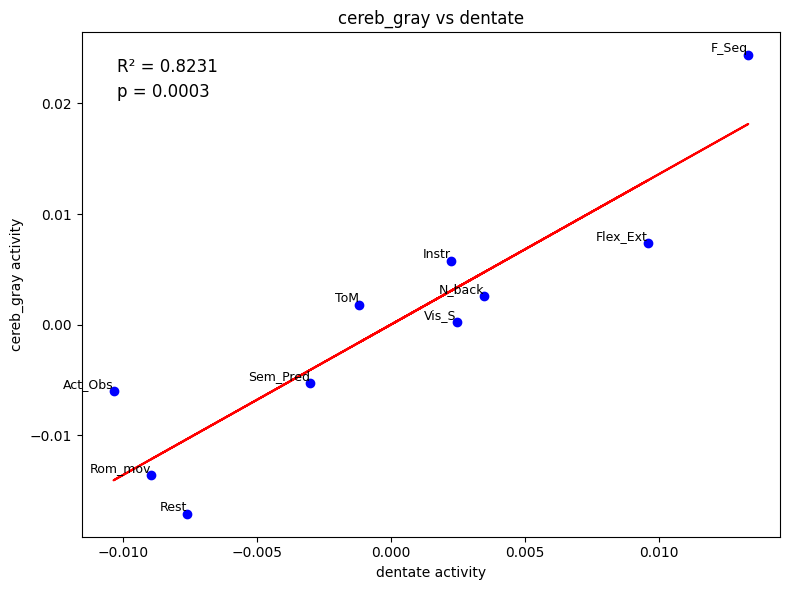

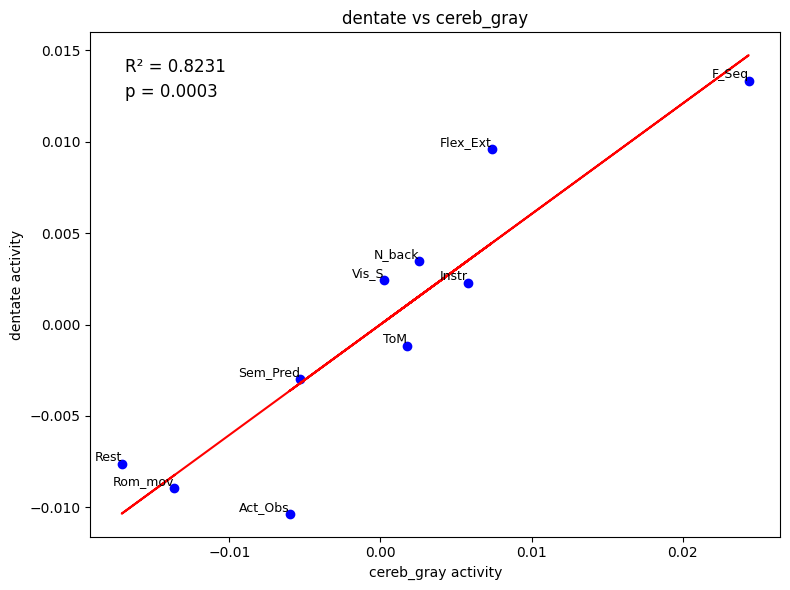

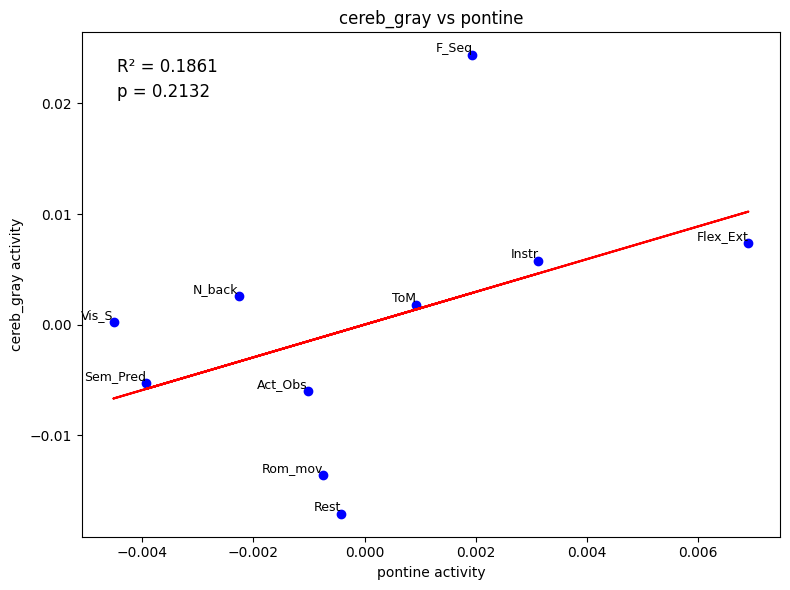

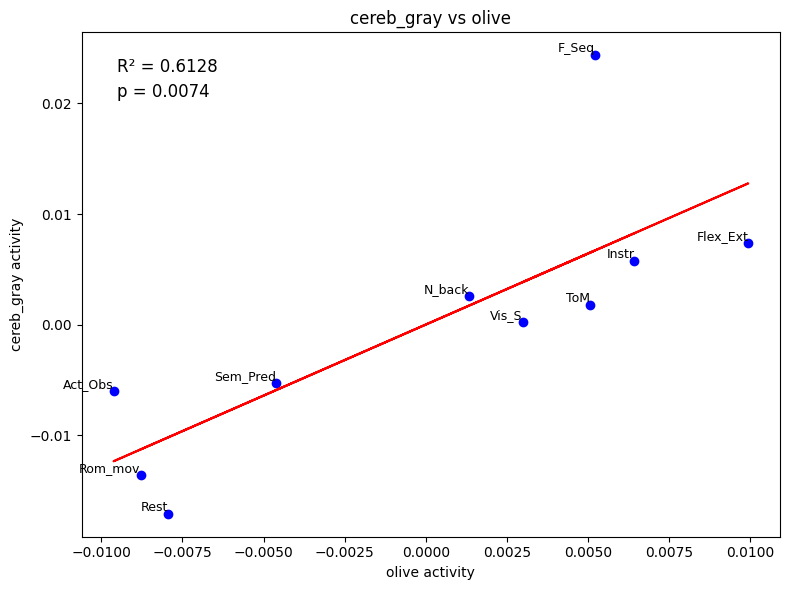

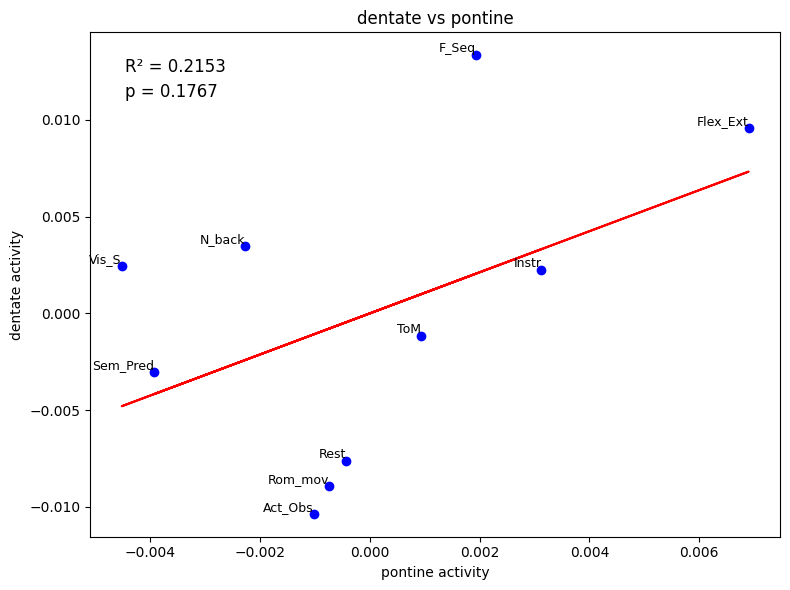

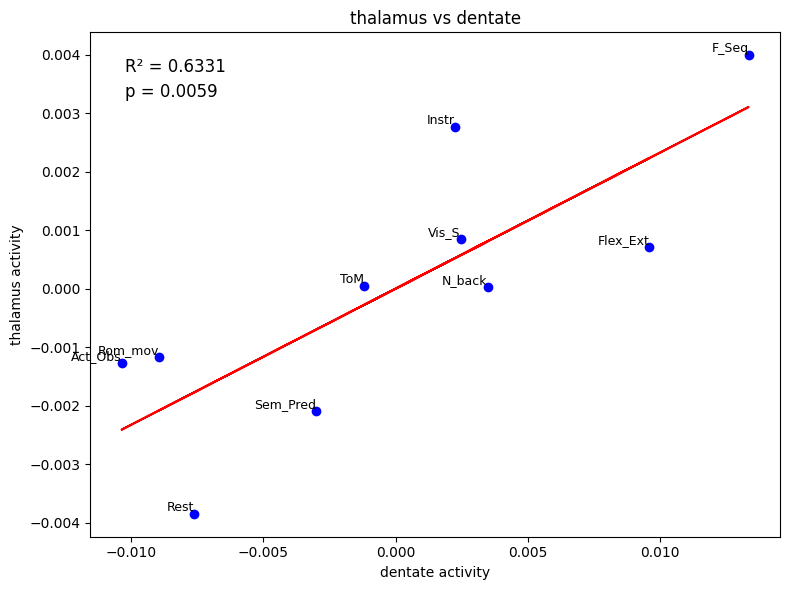

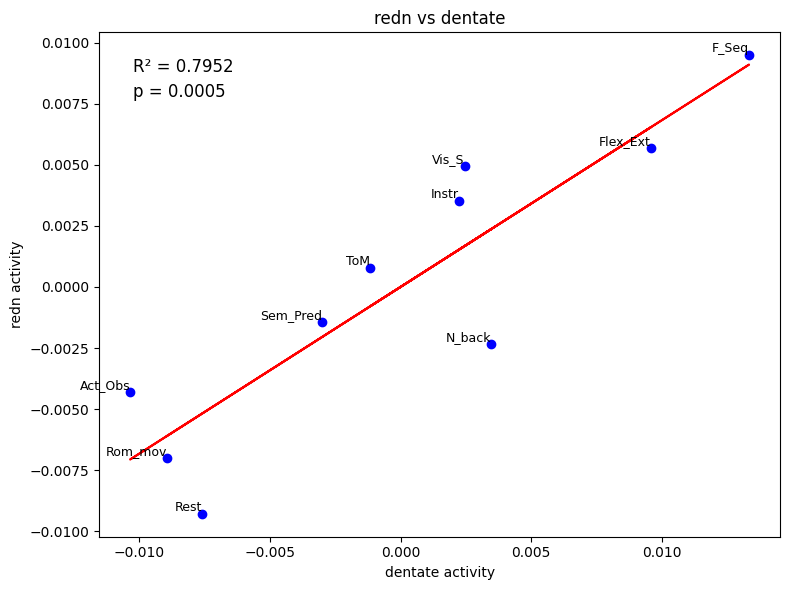

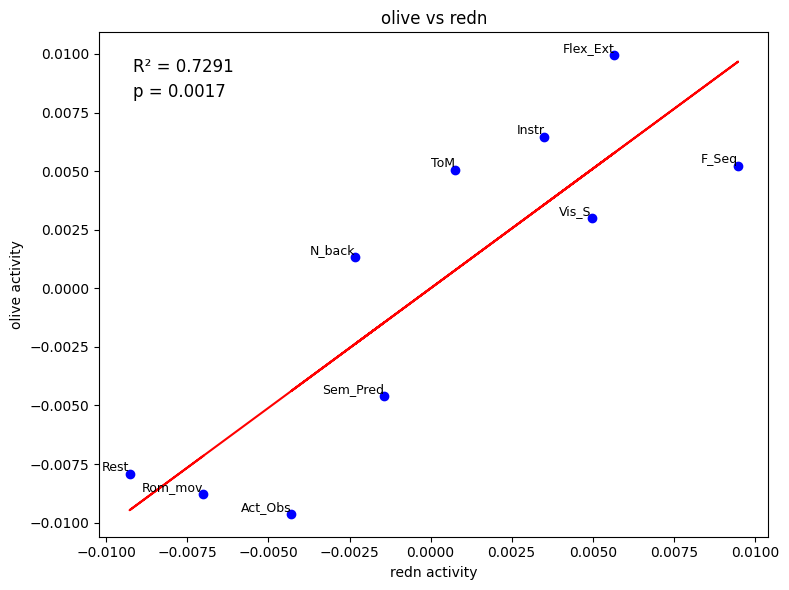

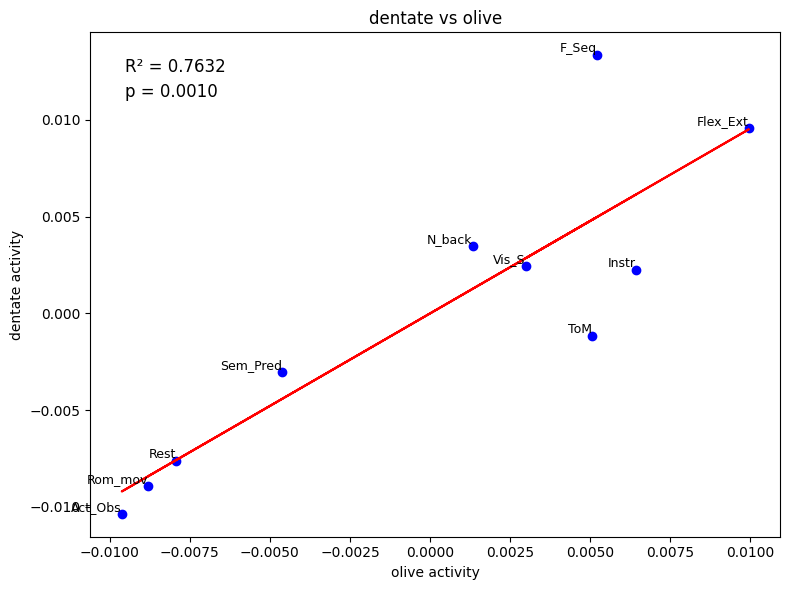

In [64]:
# Load the dataset
df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

# List of ROI pairs to loop over
roi_pairs = [
    "cereb_gray vs dentate",
    "dentate vs cereb_gray",
    "cereb_gray vs pontine",
    "cereb_gray vs olive",
    "dentate vs pontine",
    "thalamus vs dentate",
    "redn vs dentate",
    "olive vs redn",
    "dentate vs olive",
]

# Loop over each ROI pair
for roi in roi_pairs:
    roi_data = df[df['ROIs'] == roi]

    # Extract the data for plotting
    x = roi_data['x']
    y = roi_data['y']
    condition_labels = roi_data['cond']

    # Regression line parsing
    regression_line = roi_data['regression line'].iloc[0]
    slope, intercept = map(float, regression_line.split(" * x + "))

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color="blue")

    # Plot regression line
    plt.plot(x, slope * x + intercept, color="red")

    # Add labels and title
    plt.xlabel(f"{roi.split(' vs ')[1]} activity")
    plt.ylabel(f"{roi.split(' vs ')[0]} activity")
    plt.title(f"{roi}")

    # Extract statistical values
    r_squared = float(roi_data['R2'].iloc[0])
    p_value = float(roi_data['p-value'].iloc[0])

    # Display R² and p-value on the plot
    plt.text(0.05, 0.95, f"R² = {r_squared:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')
    plt.text(0.05, 0.90, f"p = {p_value:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')

    # Add condition labels to points
    for i, label in enumerate(condition_labels):
        plt.text(x.iloc[i], y.iloc[i], label, fontsize=9, color='black', ha='right', va='bottom')

    # Show the plot
    plt.tight_layout()
    plt.show()


In [166]:
#group: list R^2 values and p-value per roi

df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

# Iterate over each subject and selected ROI combination
for roi in df['ROIs'].unique():  # Iterate over each unique roi

    roi_data = df[df['ROIs'] == roi]  # Filter data for the current ROI
   
    r_squared = roi_data['R2'].iloc[0]  
    p_value = roi_data['p-value'].iloc[0]
        
        # Print the R² value for the subject-ROI pair
    print(f"group {roi}: R² = {r_squared:.4f}, p = {p_value:.4f}")


group dentate vs cereb_gray: R² = 0.8231, p = 0.0003
group cereb_gray vs pontine: R² = 0.1861, p = 0.2132
group cereb_gray vs olive: R² = 0.6128, p = 0.0074
group thalamus vs dentate: R² = 0.6331, p = 0.0059
group dentate vs pontine: R² = 0.2153, p = 0.1767
group redn vs dentate: R² = 0.7952, p = 0.0005
group olive vs redn: R² = 0.7291, p = 0.0017
group dentate vs olive: R² = 0.7632, p = 0.0010


In [52]:
#subject-wise regression (creating .tsv files)

#dentate vs cereb_gray
#cereb_gray vs pontine
#cereb_gray vs olive
#dentate vs pontine
#thalamus vs dentate
#redn vs dentate
#olive vs redn
#dentate vs olive

pt_base ='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T'

T = pd.read_csv(f'{pt_base}/participants.tsv', sep='\t')
subj = [i for i, good_value in zip(T.participant_id, T.good) if good_value == 1]

subj_avg_cereb_gray = np.mean(olive, axis=(1,3))  # shape (16,10) (subjects x conditions)
subj_avg_dentate = np.mean(dentate, axis=(1,3))  # shape  (16,10)

condition_labels = ["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"]

results = []

for subj_idx, subj_id in enumerate(subj):
    x = subj_avg_dentate[subj_idx, :]
    y = subj_avg_cereb_gray[subj_idx, :]

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    regression_line = f"{slope:.4f} * x + {intercept:.4f}"
    F_value = (r_value**2 / (1 - r_value**2)) * ((len(condition_labels) - 2) / 1)
    
    # t-value for slope significance
    t_value = slope / std_err  
    slope_p_value = 2 * t.sf(abs(t_value), df=len(condition_labels) - 2)  # Two-tailed test

    for i in range(len(condition_labels)):
        results.append([
            subj_id, 
            "cereb_gray vs dentate", 
            condition_labels[i], 
            x[i], 
            y[i], 
            regression_line, 
            r_value**2, 
            F_value, 
            p_value,
            std_err,          # Standard Error of the slope
            t_value,          # t-value for slope significance
            slope_p_value     # p-value for slope significance
        ])

# Convert to DataFrame
df = pd.DataFrame(results, columns=[
    "Subjects", "ROIs", "cond", "x", "y", 
    "regression line", "R2", "F-value", "p-value",
    "SE_slope", "t-value", "slope_p-value"
])

# Save to TSV
df.to_csv("subjectwise_ROI_correlations.tsv", sep="\t", mode='a', index=False)


In [57]:
#t-test slopes

# Read the data from your .tsv file
df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")

# Define the list of ROI pairs you want to include
roi_pairs = [
    "cereb_gray vs pontine",
    "cereb_gray vs olive",
    "dentate vs pontine",
    "thalamus vs dentate",
    "redn vs dentate",
    "olive vs redn",
    "dentate vs olive",
    "dentate vs cereb_gray",
    "cereb_gray vs dentate"
]

# Iterate over each ROI pair
for roi_pair in roi_pairs:
    # Filter the DataFrame to only include the selected ROI pair
    df_filtered = df[df['ROIs'] == roi_pair]
    
    # Create an empty list to store the slopes for each subject
    slopes = []

    # Iterate over each subject in the filtered DataFrame
    for subj_id in df_filtered['Subjects'].unique():  # Iterate over each unique subject
        subject_data = df_filtered[df_filtered['Subjects'] == subj_id]
        
        # Extract the regression line for the subject and ROI pair
        regression_line = subject_data['regression line'].iloc[0]  # Assuming one regression line per subject/ROI pair
        
        # Extract the slope from the regression line string
        slope_str = regression_line.split(' * x')[0]  # Get the part before ' * x'
        
        # Convert the slope part to a float
        try:
            slope = float(slope_str)
        except ValueError:
            slope = None  # In case the string can't be converted to a float
        
        # Append the extracted slope to the list
        if slope is not None:
            slopes.append(slope)

    slopes_array = np.array(slopes)

    # Perform one-sample t-test on the slopes
    t_stat, p_val = ttest_1samp(slopes_array, 0)

    # Print the result for the current ROI pair
    print(f"ROI Pair: {roi_pair}")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_val}")
    print("-" * 40)


ROI Pair: cereb_gray vs pontine
T-statistic: 4.364552901269085
P-value: 0.0005549673887178172
----------------------------------------
ROI Pair: cereb_gray vs olive
T-statistic: 3.0475301173327733
P-value: 0.008144392046575487
----------------------------------------
ROI Pair: dentate vs pontine
T-statistic: 2.330721249715938
P-value: 0.03413234689488446
----------------------------------------
ROI Pair: thalamus vs dentate
T-statistic: 3.59068026233279
P-value: 0.0026763273136597076
----------------------------------------
ROI Pair: redn vs dentate
T-statistic: 2.3901716391725945
P-value: 0.030403093065076502
----------------------------------------
ROI Pair: olive vs redn
T-statistic: -0.31498400315614933
P-value: 0.7571130467968415
----------------------------------------
ROI Pair: dentate vs olive
T-statistic: 2.765653400931503
P-value: 0.014424541758493241
----------------------------------------
ROI Pair: dentate vs cereb_gray
T-statistic: 9.132960356730491
P-value: 1.62531607520

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


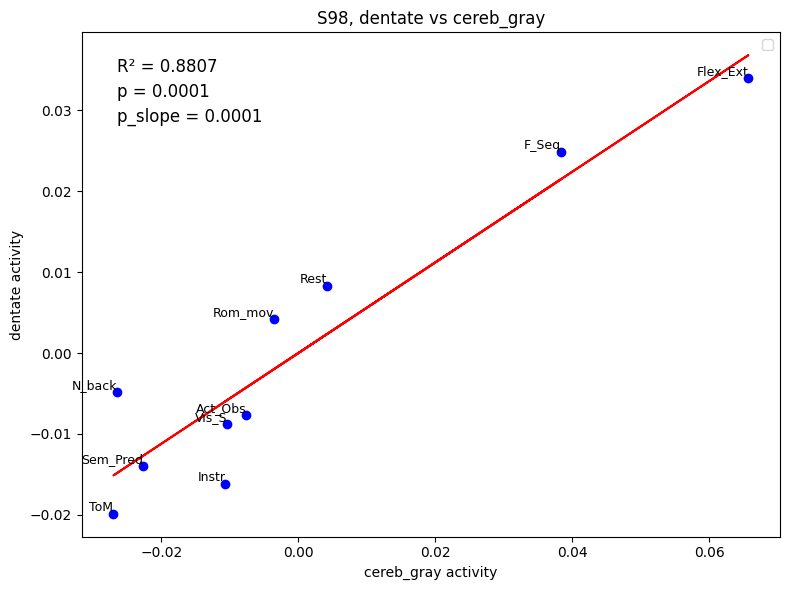

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


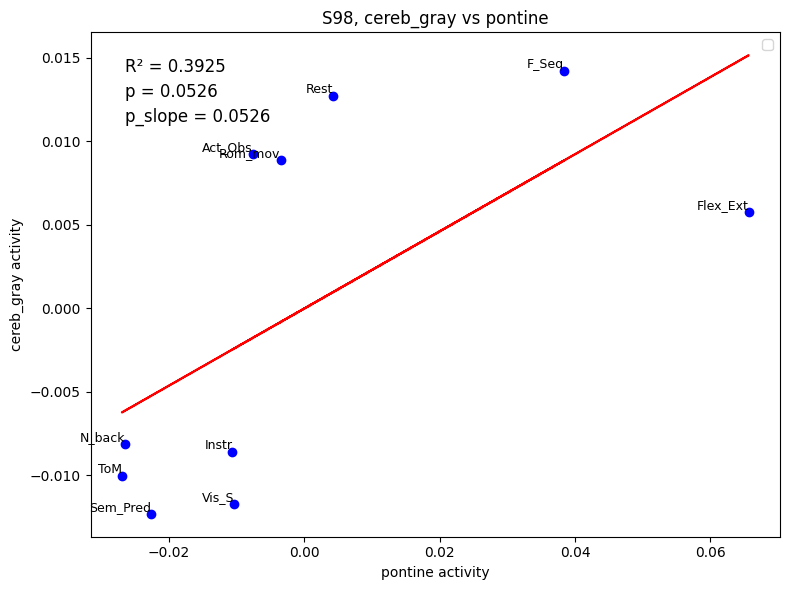

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


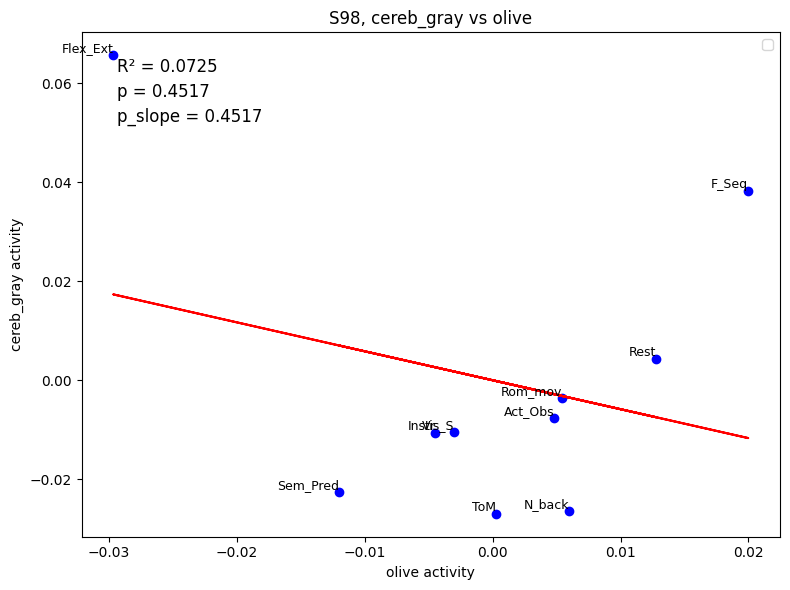

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


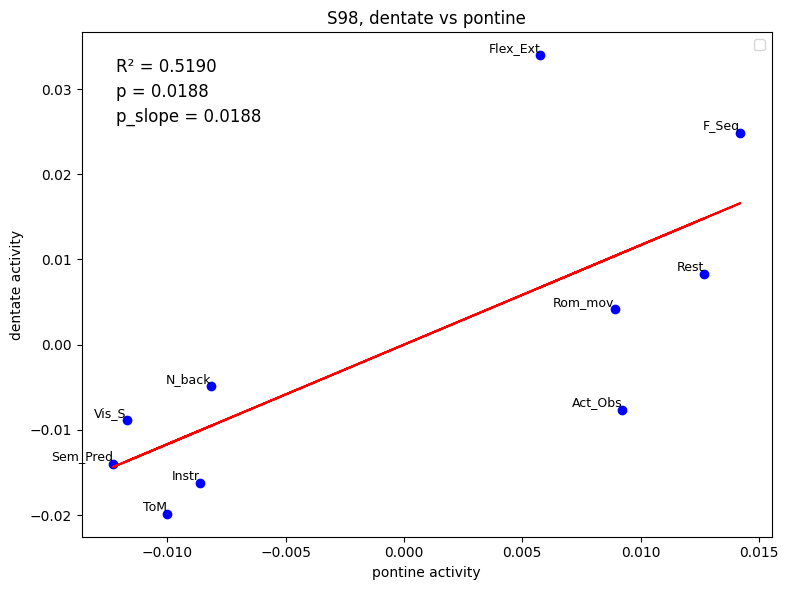

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


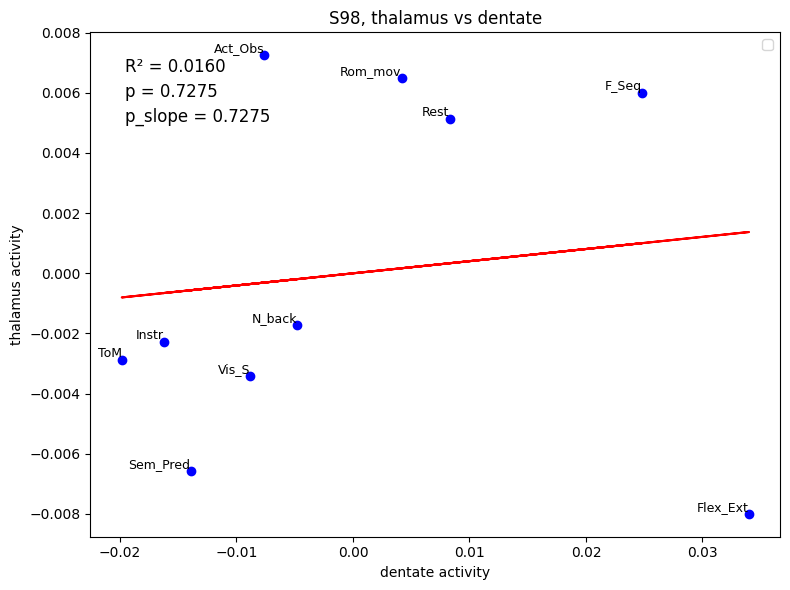

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


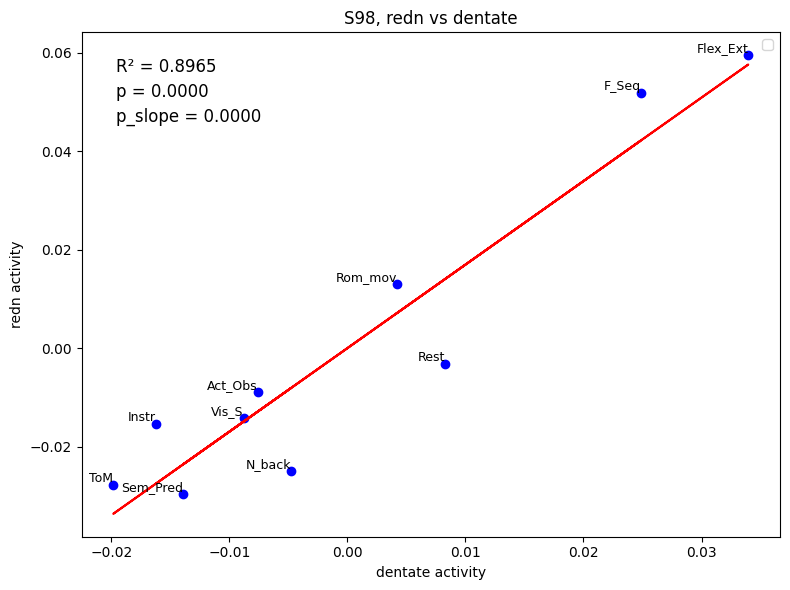

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


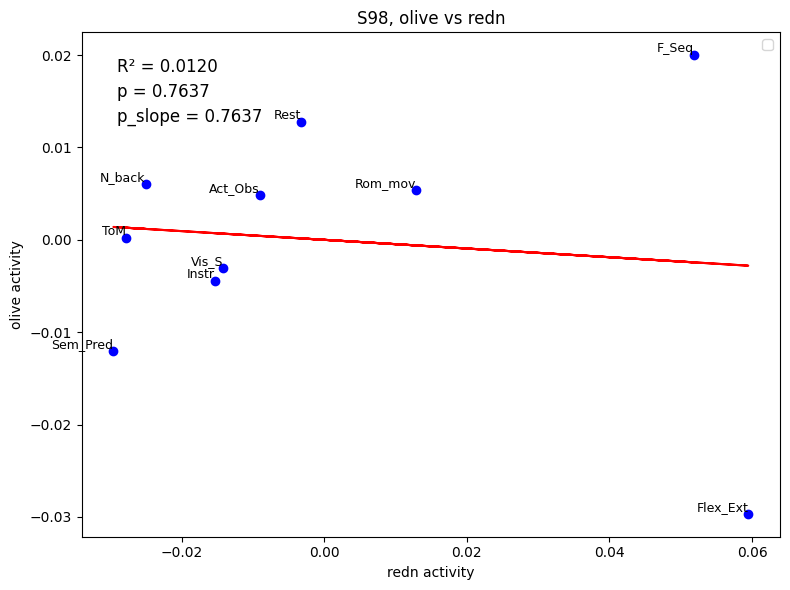

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


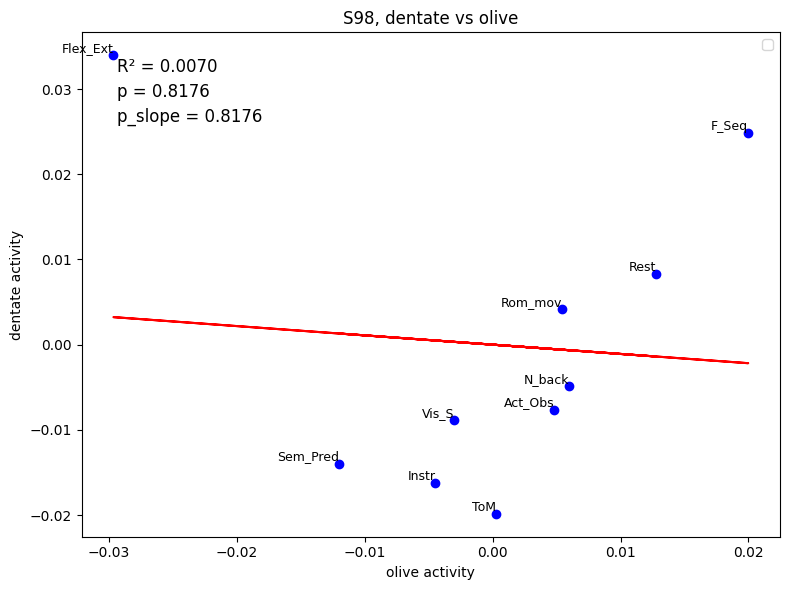

In [18]:

# Read the data from the .tsv file
df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")

subject_id = 'S98'  # Specify the subject
subject_data = df[df['Subjects'] == subject_id]

# Loop through each ROI (or filter if needed)
for roi in subject_data['ROIs'].unique():  # Loop through the unique ROIs
    roi_data = subject_data[subject_data['ROIs'] == roi]

    # Extract the data for plotting
    x = roi_data['x']
    y = roi_data['y']
    condition_labels = roi_data['cond']
    regression_line = roi_data['regression line'].iloc[0]  # Assuming the same regression line for each ROI

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color="blue")

    # Extract slope and intercept for the regression line
    slope, intercept = map(float, regression_line.split(" * x + "))  # This assumes your regression line is in the form "slope * x + intercept"
    plt.plot(x, slope * x + intercept, color="red")

    # Add labels and title
    plt.xlabel(f"{roi.split(' vs ')[1]} activity")
    plt.ylabel(f"{roi.split(' vs ')[0]} activity")
    plt.title(f"{subject_id}, {roi}")
    plt.legend()

    r_squared = float(roi_data['R2'].iloc[0])  # Extract the R² value from the dataframe for this ROI
    p_value = float(roi_data['p-value'].iloc[0])  # Extract the p-value from the dataframe for this ROI
    p_value_slope = float(roi_data['slope_p-value'].iloc[0])

    # Display R² and p-value on the plot
    plt.text(0.05, 0.95, f"R² = {r_squared:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')
    plt.text(0.05, 0.90, f"p = {p_value:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')
    plt.text(0.05, 0.85, f"p_slope = {p_value:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')


    # Optionally, add labels for conditions
    for i, label in enumerate(condition_labels):  # Use enumerate to iterate over condition labels
        plt.text(x.iloc[i], y.iloc[i], label, fontsize=9, color='black', ha='right', va='bottom')

    # Show the plot
    plt.tight_layout()
    plt.show()


In [25]:
#List R^2 values and p-value per subject

# Load the .tsv file
df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")

# Define the ROIs you want to include
selected_rois = ["dentate vs cereb_gray"]  # Replace with actual ROI names

# Filter the DataFrame to only include selected ROIs
df_filtered = df[df['ROIs'].isin(selected_rois)]

# Iterate over each subject and selected ROI combination
for subj_id in df_filtered['Subjects'].unique():  # Iterate over each unique subject
    subject_data = df_filtered[df_filtered['Subjects'] == subj_id]
    
    for roi in subject_data['ROIs'].unique():  # Iterate over each unique selected ROI
        roi_data = subject_data[subject_data['ROIs'] == roi]
        
        # Extract the R² value (assuming it's stored in the "R2" column)
        r_squared = roi_data['R2'].iloc[0]  # Assuming the R² value is the same for all conditions within a subject-ROI pair
        p_value = roi_data['p-value'].iloc[0]
        p_value_slope = roi_data['slope_p-value'].iloc[0]   
        
        # Print the R² value for the subject-ROI pair
        print(f"Subject {subj_id}, ROI {roi}: R² = {r_squared:.4f}, p = {p_value:.4f}, p_slope = {p_value_slope:.4f}")


Subject S98, ROI dentate vs cereb_gray: R² = 0.8807, p = 0.0001, p_slope = 0.0001
Subject S97, ROI dentate vs cereb_gray: R² = 0.7890, p = 0.0006, p_slope = 0.0006
Subject S96, ROI dentate vs cereb_gray: R² = 0.7409, p = 0.0014, p_slope = 0.0014
Subject S95, ROI dentate vs cereb_gray: R² = 0.3772, p = 0.0589, p_slope = 0.0589
Subject S01, ROI dentate vs cereb_gray: R² = 0.5847, p = 0.0100, p_slope = 0.0100
Subject S03, ROI dentate vs cereb_gray: R² = 0.7212, p = 0.0019, p_slope = 0.0019
Subject S04, ROI dentate vs cereb_gray: R² = 0.7009, p = 0.0025, p_slope = 0.0025
Subject S07, ROI dentate vs cereb_gray: R² = 0.7040, p = 0.0024, p_slope = 0.0024
Subject S08, ROI dentate vs cereb_gray: R² = 0.2900, p = 0.1083, p_slope = 0.1083
Subject S10, ROI dentate vs cereb_gray: R² = 0.2445, p = 0.1463, p_slope = 0.1463
Subject S11, ROI dentate vs cereb_gray: R² = 0.0003, p = 0.9596, p_slope = 0.9596
Subject S12, ROI dentate vs cereb_gray: R² = 0.0675, p = 0.4685, p_slope = 0.4685
Subject S13, ROI

In [29]:
#cereb_gray vs pontine
#cereb_gray vs olive
#dentate vs pontine
#thalamus vs dentate
#redn vs dentate
#olive vs redn
#dentate vs olive
#dentate vs cereb_gray

# Compute ANOVA and t-tests
df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")

selected_rois = ["dentate vs cereb_gray"]

# Filter the DataFrame for selected ROIs and R² > 0.50
df_filtered = df[(df['ROIs'].isin(selected_rois)) & (df['slope_p-value'] < 0.05)]


# Create an empty list to store residuals for each condition
residuals = []

# Loop through the unique conditions
for condition in df_filtered['cond'].unique():
    condition_data = df_filtered[df_filtered['cond'] == condition]
    
    condition_residuals = []
    
    # Loop through each subject to calculate residuals based on their own regression line
    for subj_id in condition_data['Subjects'].unique():
        subject_data = condition_data[condition_data['Subjects'] == subj_id]
        
        x = subject_data['x']
        y = subject_data['y']
        
        # Extract the regression line (slope, intercept)
        regression_line = subject_data['regression line'].iloc[0] 
        slope, intercept = map(float, regression_line.split(" * x + "))
        
        # Calculate predicted y-values based on the regression line
        predicted_y = slope * x + intercept
        
        # Calculate residuals (observed y - predicted y)
        residuals_for_subject = y - predicted_y
        
        # Append subject's residuals to the condition's list
        condition_residuals.append(residuals_for_subject)
    
    # After looping through subjects for this condition, add the residuals for this condition
    residuals.append(np.array(condition_residuals).T)  # Transpose to get subjects as rows

residuals = np.array(residuals).T  # shape is (subjects x 1 x conditions) (10,1,10)

residuals = residuals.squeeze()

residuals = residuals.T  # shape is (conditions x subjects) (10,10)

# Perform one-way ANOVA across conditions (i.e., residuals across all subjects for each condition)
F_value, p_value = f_oneway(*residuals)

print(f"{selected_rois}")
print(f"ANOVA F-value: {F_value:.4f}")
print(f"ANOVA p-value: {p_value:.4f}")

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Prepare data for Tukey’s HSD
residuals_flat = residuals.flatten()
conditions_repeated = np.repeat(df_filtered['cond'].unique(), residuals.shape[1])

# Perform Tukey’s HSD
tukey_results = pairwise_tukeyhsd(endog=residuals_flat,  # Data values
                                  groups=conditions_repeated,  # Condition labels
                                  alpha=0.05)  # Significance level

# Display results
print(tukey_results)


# Collect t-values and p-values
t_values = []
p_values = []

for i in range (10): #number of conditions
    t_stat, p_val = ttest_1samp(residuals[i, :], 0)
    t_values.append(t_stat)
    p_values.append(p_val)

# Apply FDR correction
reject, p_values_corrected, _, _ = multipletests(p_values, alpha=0.1, method='fdr_bh')

# Store flagged results
flagged_results = []

for i, cond in enumerate(df_filtered['cond'].unique()):
    t_stat, p_val, p_val_corrected = t_values[i], p_values[i], p_values_corrected[i]
    
    # Flag conditions with corrected p-value < 0.05
    flag = "Significant" if reject[i] else "Not Significant"
    
    flagged_results.append([cond, t_stat, p_val, p_val_corrected, flag])

# Convert flagged results to DataFrame
flagged_df = pd.DataFrame(flagged_results, 
                          columns=["Condition", "T-statistic", "P-value", "FDR P-value", "Significance (FDR)"])

# Display the flagged results
print(flagged_df)


['dentate vs cereb_gray']
ANOVA F-value: 3.1651
ANOVA p-value: 0.0023
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
 Act_Obs    F_Seq   0.0099 0.0322  0.0005 0.0193   True
 Act_Obs Flex_Ext    0.012  0.003  0.0026 0.0214   True
 Act_Obs    Instr   0.0065 0.4426 -0.0029 0.0159  False
 Act_Obs   N_back   0.0105 0.0172  0.0011 0.0199   True
 Act_Obs     Rest   0.0069 0.3448 -0.0025 0.0164  False
 Act_Obs  Rom_mov   0.0051 0.7556 -0.0043 0.0145  False
 Act_Obs Sem_Pred   0.0089 0.0826 -0.0006 0.0183  False
 Act_Obs      ToM   0.0088 0.0864 -0.0006 0.0182  False
 Act_Obs    Vis_S   0.0121 0.0026  0.0027 0.0216   True
   F_Seq Flex_Ext   0.0022 0.9991 -0.0073 0.0116  False
   F_Seq    Instr  -0.0034 0.9755 -0.0128  0.006  False
   F_Seq   N_back   0.0006    1.0 -0.0088   0.01  False
   F_Seq     Rest  -0.0029 0.9909 -0.0124 0.0065  False
   F_Seq  Rom_mov  -0.0048 0.8266 

In [42]:
# t-tests of residuals using group regression line as reference 

df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")
group_df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

all_rois = df['ROIs'].unique()

# Iterate over each ROI pair
for roi_pair in all_rois:
    # Filter data for the current ROI pair
    df_filtered = df[df['ROIs'] == roi_pair]

    residuals = []

# Loop through the unique conditions
    for condition in df_filtered['cond'].unique():
        condition_data = df_filtered[df_filtered['cond'] == condition]
    
        condition_residuals = []
    
    # Extract the GROUP regression line for this ROI and condition
        group_regression_line = group_df[(group_df['ROIs'] == selected_rois[0]) &
                                     (group_df['cond'] == condition)]['regression line'].iloc[0]

    # Extract the slope and intercept from the group regression line
        slope, intercept = map(float, group_regression_line.split(" * x + "))

    # Loop through each subject to calculate residuals based on the group regression line
        for subj_id in condition_data['Subjects'].unique():
            subject_data = condition_data[condition_data['Subjects'] == subj_id]
        
            x = subject_data['x']
            y = subject_data['y']
        
            # Calculate predicted y-values based on the GROUP regression line
            predicted_y = slope * x + intercept
        
            residuals_for_subject = y - predicted_y
        
        # Append subject's residuals to the condition's list
            condition_residuals.append(residuals_for_subject)
    
    # After looping through subjects for this condition, add the residuals for this condition
        residuals.append(np.array(condition_residuals).T)  # Transpose to get subjects as rows

# Format residuals for ANOVA
residuals = np.array(residuals).T  
residuals = residuals.squeeze()
residuals = residuals.T  # shape is (conditions x subjects)

# Perform one-way ANOVA across conditions
F_value, p_value = f_oneway(*residuals)

# Collect t-values and p-values for t-test
t_values = []
p_values = []

for i in range(10):  # Number of conditions
    t_stat, p_val = ttest_1samp(residuals[i, :], 0)
    t_values.append(t_stat)
    p_values.append(p_val)

# Apply FDR correction
reject, p_values_corrected, _, _ = multipletests(p_values, alpha=0.1, method='fdr_bh')

# Store flagged results
flagged_results = []

for i, cond in enumerate(df_filtered['cond'].unique()):
    t_stat, p_val, p_val_corrected = t_values[i], p_values[i], p_values_corrected[i]
    
    # Flag conditions with corrected p-value < 0.05
    flag = "Significant" if reject[i] else "Not Significant"
    
    flagged_results.append([cond, t_stat, p_val, p_val_corrected, flag])

# Convert flagged results to DataFrame
flagged_df = pd.DataFrame(flagged_results, 
                          columns=["Condition", "T-statistic", "P-value", "FDR P-value", "Significance (FDR)"])

print(selected_rois)
print(flagged_df)


['dentate vs cereb_gray']
  Condition  T-statistic   P-value  FDR P-value Significance (FDR)
0     Instr    -0.834820  0.416917     0.598228    Not Significant
1     Vis_S     0.242028  0.812036     0.902263    Not Significant
2     F_Seq     2.849331  0.012183     0.121830    Not Significant
3       ToM    -0.726727  0.478582     0.598228    Not Significant
4    N_back     1.024621  0.321783     0.598228    Not Significant
5  Sem_Pred    -0.120309  0.905835     0.905835    Not Significant
6   Act_Obs    -1.418661  0.176441     0.598228    Not Significant
7  Flex_Ext     0.823426  0.423165     0.598228    Not Significant
8      Rest    -0.748125  0.465954     0.598228    Not Significant
9   Rom_mov    -0.872115  0.396891     0.598228    Not Significant


In [67]:
#t-tests on condition residuals

df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")
group_df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

# Extract all unique ROI pairs
all_rois = df['ROIs'].unique()

# Create a container for flagged results
all_flagged_results = []

# Iterate over each ROI pair
for roi_pair in all_rois:
    # Filter data for the current ROI pair
    df_filtered = df[df['ROIs'] == roi_pair]

    residuals = []

    # Loop through the unique conditions
    for condition in df_filtered['cond'].unique():
        condition_data = df_filtered[df_filtered['cond'] == condition]

        condition_residuals = []

        # Extract the GROUP regression line for this ROI and condition
        group_regression_line = group_df[(group_df['ROIs'] == roi_pair) &
                                         (group_df['cond'] == condition)]['regression line'].iloc[0]

        # Extract the slope and intercept from the group regression line
        slope, intercept = map(float, group_regression_line.split(" * x + "))

        # Loop through each subject to calculate residuals based on the group regression line
        for subj_id in condition_data['Subjects'].unique():
            subject_data = condition_data[condition_data['Subjects'] == subj_id]

            x = subject_data['x']
            y = subject_data['y']

            # Calculate predicted y-values based on the GROUP regression line
            predicted_y = slope * x + intercept

            residuals_for_subject = y - predicted_y

            # Append subject's residuals to the condition's list
            condition_residuals.append(residuals_for_subject)

        # After looping through subjects for this condition, add the residuals for this condition
        residuals.append(np.array(condition_residuals).T)  # Transpose to get subjects as rows

    # Format residuals for t-tests
    residuals = np.array(residuals).T
    residuals = residuals.squeeze()
    residuals = residuals.T  # shape is (conditions x subjects)

    # Collect t-values and p-values for t-test
    t_values = []
    p_values = []

    for i in range(residuals.shape[0]):  # Number of conditions
        t_stat, p_val = ttest_1samp(residuals[i, :], 0)
        t_values.append(t_stat)
        p_values.append(p_val)

    # Apply FDR correction
    reject, p_values_corrected, _, _ = multipletests(p_values, alpha=0.1, method='fdr_bh')

    # Store flagged results
    for i, cond in enumerate(df_filtered['cond'].unique()):
        t_stat, p_val, p_val_corrected = t_values[i], p_values[i], p_values_corrected[i]

        # Flag conditions with corrected p-value < 0.05
        flag = "Significant" if reject[i] else "Not Significant"

        all_flagged_results.append([roi_pair, cond, t_stat, p_val, p_val_corrected, flag])

# Convert flagged results to DataFrame
flagged_df = pd.DataFrame(all_flagged_results,
                          columns=["ROI Pair", "Condition", "T-statistic", "P-value", 
                                   "FDR P-value", "Significance (FDR)"])

flagged_df.to_csv('residual_t-tests.csv',index=False)


In [68]:
# Load the .tsv file
file_path = "residual_t-tests.csv"  # Replace with your actual file path
df = pd.read_csv(file_path, sep=',')

# Assuming the p-values are in a column named 'p_value'
significant_rows = df[df["Significance (FDR)"] == "Significant"]

# Print significant rows
print(significant_rows)


                 ROI Pair Condition  T-statistic   P-value  FDR P-value  \
6   dentate vs cereb_gray   Act_Obs    -3.015890  0.008687     0.086870   
12  cereb_gray vs pontine     F_Seq    -6.739482  0.000007     0.000066   
18  cereb_gray vs pontine      Rest     5.095801  0.000132     0.000555   
19  cereb_gray vs pontine   Rom_mov     4.974368  0.000166     0.000555   
31     dentate vs pontine     Vis_S     2.488471  0.025070     0.058560   
32     dentate vs pontine     F_Seq     2.373400  0.031414     0.058560   
34     dentate vs pontine    N_back     2.366356  0.031848     0.058560   
36     dentate vs pontine   Act_Obs    -2.953999  0.009853     0.058560   
38     dentate vs pontine      Rest    -2.532084  0.023000     0.058560   
39     dentate vs pontine   Rom_mov    -2.315765  0.035136     0.058560   
40    thalamus vs dentate     Instr     5.153340  0.000118     0.001178   
48    thalamus vs dentate      Rest    -2.825673  0.012780     0.063899   

   Significance (FDR)  


In [65]:
#ANOVA and Tukey’s HSD for all ROI pairs with group as reference

df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")
group_df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

# Extract all unique ROI pairs
all_rois = df['ROIs'].unique()

# Create containers for results
anova_results = []
tukey_results_list = []
flagged_results = []

# Iterate over each ROI pair
for roi_pair in all_rois:
    # Filter data for the current ROI pair
    df_filtered = df[df['ROIs'] == roi_pair]

    # Create an empty list to store residuals for each condition
    residuals = []

    # Loop through conditions
    for condition in df_filtered['cond'].unique():
        condition_data = df_filtered[df_filtered['cond'] == condition]

        # Extract the GROUP regression line for this ROI and condition
        group_regression_line = group_df[(group_df['ROIs'] == roi_pair) &
                                         (group_df['cond'] == condition)]['regression line'].iloc[0]

        # Extract the slope and intercept
        slope, intercept = map(float, group_regression_line.split(" * x + "))

        # Collect residuals
        condition_residuals = []

        # Loop through each subject
        for subj_id in condition_data['Subjects'].unique():
            subject_data = condition_data[condition_data['Subjects'] == subj_id]

            x = subject_data['x']
            y = subject_data['y']

            # Predicted y-values based on the group regression line
            predicted_y = slope * x + intercept
            residuals_for_subject = y - predicted_y

            condition_residuals.append(residuals_for_subject)

        residuals.append(np.array(condition_residuals).T)  # Transpose to get subjects as rows

    # Format residuals for ANOVA
    residuals = np.array(residuals).T  
    residuals = residuals.squeeze()
    residuals = residuals.T  # shape is (conditions x subjects)

    # Perform one-way ANOVA
    F_value, p_value = f_oneway(*residuals)

    # Store ANOVA results
    anova_results.append([roi_pair, F_value, p_value])

    # Tukey’s HSD
    residuals_flat = residuals.flatten()
    conditions_repeated = np.repeat(df_filtered['cond'].unique(), residuals.shape[1])

    tukey_results = pairwise_tukeyhsd(endog=residuals_flat,
                                      groups=conditions_repeated,
                                      alpha=0.05)
    tukey_results_list.append([roi_pair, tukey_results])

    # Collect t-values and p-values for t-tests
    t_values = []
    p_values = []

    for i in range(residuals.shape[0]):  # Number of conditions
        t_stat, p_val = ttest_1samp(residuals[i, :], 0)
        t_values.append(t_stat)
        p_values.append(p_val)

    # Apply FDR correction
    reject, p_values_corrected, _, _ = multipletests(p_values, alpha=0.1, method='fdr_bh')

    # Store flagged results
    for i, cond in enumerate(df_filtered['cond'].unique()):
        flagged_results.append([roi_pair, cond, t_values[i], p_values[i], p_values_corrected[i],
                                "Significant" if reject[i] else "Not Significant"])

# Convert results to DataFrames
anova_df = pd.DataFrame(anova_results, columns=["ROI Pair", "ANOVA F-value", "ANOVA P-value"])
flagged_df = pd.DataFrame(flagged_results, 
                          columns=["ROI Pair", "Condition", "T-statistic", "P-value", 
                                   "FDR P-value", "Significance (FDR)"])

# Print Results
print(anova_df)
#for roi_pair, tukey_result in tukey_results_list:
    #print(f"\nTukey's HSD for {roi_pair}:")
   # print(tukey_result)

#print("\nSignificance Results (FDR):")
#print(flagged_df)


                ROI Pair  ANOVA F-value  ANOVA P-value
0  dentate vs cereb_gray       1.809105   7.089405e-02
1  cereb_gray vs pontine      11.786586   6.451919e-14
2    cereb_gray vs olive       1.764501   7.948822e-02
3     dentate vs pontine       4.707003   1.631776e-05
4    thalamus vs dentate       2.149163   2.871277e-02
5        redn vs dentate       0.551151   8.349189e-01
6          olive vs redn       0.406579   9.300854e-01
7       dentate vs olive       0.684365   7.222107e-01
8  cereb_gray vs dentate       1.093836   3.706872e-01
